# 

# Project 1: Navigation
## Udacity Deep Reinforcement Learning Nano-Degree

The goal of this project is to use the Deep Q-Learning algorithm to train an agent to solve the Unity Banana environment. The Unity Banana environment is a simple 3d environment consisting of a bounding box, and a number of blue and yellow bananas. A successful agent moves around collecting only the yellow bananas avoiding the blue ones.

For the purpose of this assignment, the task is considered solved when the agent can get an average score of +13 over 100 consecutive episodes.

## Actions

At any time, the agent can take one of four actions:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

## States

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.

## Rewards

A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana.

## Define the training routine

For the basic structure of the neural network, and the dqn agent, I used the code provided in the solution to the earlier exercise in this section. I modified the training routine to work with the Unity environment format, and I modified the parameters of the training function, dgn agent, and neural network so I could conduct a hyperparmeter search using scikit-optimize.

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from dqn_agent import Agent
import json
import random
import torch
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
from skopt import gp_minimize

%matplotlib inline

env = UnityEnvironment(file_name="env/Banana.app")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
ACTION_SIZE = brain.vector_action_space_size
print('Number of Actions:', ACTION_SIZE)
state = env_info.vector_observations[0]
STATE_SIZE = len(state)
print('State Size:', STATE_SIZE)

MAX_EPISODES=200
MAX_T=1000 
SOLVED = 13.0


def dqn(
    break_early=False,
    n_episodes=MAX_EPISODES, 
    max_t=MAX_T, 
    eps_start=1.0, 
    eps_end=0.01, 
    eps_decay=0.995,
    batch_size=64,
    update_every=4,
    fc1_units=64,
    fc2_units=64,
    lr=5e-4,
    gamma = 0.99,
    tau = 1e-3
    ):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    # print the set of parameters used in this call
    print(locals())
    
    
    # initialize agent
    agent = Agent(
        state_size=STATE_SIZE, 
        action_size=ACTION_SIZE, 
        seed=0, 
        batch_size=batch_size,
        gamma=gamma,
        tau=tau,
        lr=lr,
        update_every=update_every,
        fc1_units=fc1_units, 
        fc2_units=fc2_units
    )
    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if np.mean(scores_window) >= SOLVED:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            if break_early == True:
                break
            
    return scores

Number of Actions: 4
State Size: 37


## Do a training run of 1800 episodes with the parameters as they were taken directly from the example code.

In [11]:
scores = dqn(n_episodes=1800, break_early=True)

{'tau': 0.001, 'gamma': 0.99, 'lr': 0.0005, 'fc2_units': 64, 'fc1_units': 64, 'update_every': 4, 'batch_size': 64, 'eps_decay': 0.995, 'eps_end': 0.01, 'eps_start': 1.0, 'max_t': 1000, 'n_episodes': 1800, 'break_early': True}
Episode 496	Average Score: 13.03
Environment solved in 396 episodes!	Average Score: 13.03


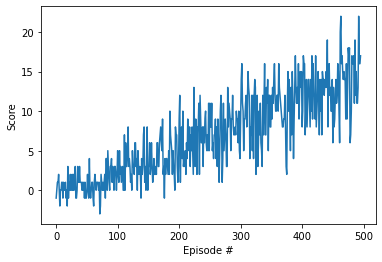

In [12]:
## Plot the scoring results

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Efficiently optimize the hyperparemeters in a bayesian way using Gaussian Process Regression

Because evaluating different hyperparameter combinations is expensive, I limited the number of episodes to 200 for each attempt during the hyperparameter search. My thinking here is that while the task won't be solved in 200 episodes, that should be enough to give a signal in terms of the best hyperparameters.

In [1]:
# define the search space for bayesian optimization
space  = [Integer(32,64, name="batch_size"),
          Integer(2, 10, name="update_every"),
          Integer(32, 128, name="fc1_units"),
          Integer(32, 128, name="fc2_units"),
          Real(1e-5, 1e0, "log-uniform", name='eps_decay'),
          Real(1e-5, 1e0, "log-uniform", name='lr'),
          Real(1e-5, 1e0, "log-uniform", name="gamma"),
          Real(1e-5, 1e0, "log-uniform", name="tau")]


@use_named_args(space)
def objective(**params):
    scores = dqn(**params)

    return -np.mean(scores[-100:])

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of Actions: 4
State Size: 37
{'tau': 1.921165975741198e-05, 'gamma': 0.0003073781785362612, 'lr': 0.0008354270566129826, 'fc2_units': 113, 'fc1_units': 114, 'update_every': 9, 'batch_size': 51, 'eps_decay': 0.013116515715358098, 'eps_end': 0.01, 'eps_start': 1.0, 'max_t': 1000, 'n_episodes': 200}
Episode 200	Average Score: 0.10{'tau': 0.017412429067220004, 'gamma': 0.0004863857046189474, 'lr': 0.15149343663386153, 'fc2_units': 78, 'fc1_units': 110, 'update_every': 6, 'batch_size': 41, 'eps_decay': 0.0009202884691104562, 'eps_end': 0.01, 'eps_start': 1.0, 'max_t': 1000, 'n_episodes': 200}
Episode 200	Average Score: -0.01{'tau': 0.02479691484362036, 'gamma': 0.004003016661601729, 'lr': 0.10105405843110161, 'fc2_units': 116, 'fc1_units': 45, 'update_every': 10, 'batch_size': 44, 'eps_decay': 0.0023336742079960397, 'eps_end': 0.01, 'eps_start': 1.0, 'max_t': 1000, 'n_episodes': 200}
Episode 200	Average Score: -0.03{'tau': 0.04837164819928406, 'gamma': 8.544009383165993e-05, 'lr': 0.

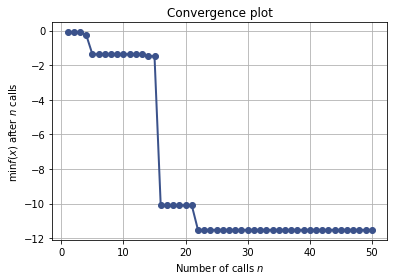

In [4]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

## Run a full training iteration with 1800 episodes

Now that we've found optimal hyperparameters, we will do a full training run of 1800 episodes, saving the checkpoint when we achieve +13 score.

In [13]:
# show the best score achieved with optimal hyperparameters
print(f"Best score on 200 episodes: {-res_gp.fun}")

# extract the parameters used for the best score, and (parameters we didn't change)
params = {
    'break_early': True,
    'eps_start': 1.0,
    'eps_end': 0.01,
    'max_t': 1000, 
    'n_episodes': 1800,
    'batch_size': res_gp.x[0],
    'update_every': res_gp.x[1],
    'fc2_units': res_gp.x[2],
    'fc1_units': res_gp.x[3],
    'eps_decay': res_gp.x[4],
    'lr': res_gp.x[5],
    'tau': res_gp.x[7],
    'gamma': res_gp.x[6]    
}

# run a full training run of 1800 episodes
scores = dqn(**params)

Best score on 200 episodes: 11.52
{'tau': 3.8801065755411095e-05, 'gamma': 1.0, 'lr': 5.288386055674643e-05, 'fc2_units': 111, 'fc1_units': 115, 'update_every': 2, 'batch_size': 57, 'eps_decay': 0.00022572684710474913, 'eps_end': 0.01, 'eps_start': 1.0, 'max_t': 1000, 'n_episodes': 1800, 'break_early': True}
Episode 240	Average Score: 13.02
Environment solved in 140 episodes!	Average Score: 13.02


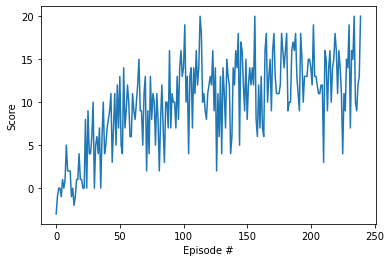

In [14]:
## Plot the scoring results

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

So, after optimizing the hyperparameters, the agent solves this task in only 240 episodes compared with 496 episodes, which is a pretty significant improvement. However, looking at the score plot the results appear less stable.

## Watched the trained agent play!

In [16]:
agent = Agent(state_size=37, action_size=4, seed=0, fc1_units=params["fc1_units"], fc2_units=params["fc2_units"])

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        time.sleep(0.05)
        if done:
            break 
            